## Leaf Shape and Size Analysis

This full workflow shows methods for analyzing the shape and size of leaves after being removed from the plant and imaged.

# Section 1: Importing libraries and image

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [17]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np

## Input variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
class options:
    def __init__(self):
        self.image = "./img/leaf_scan.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "leaf_analysis.txt"
        self.outdir = "."

In [25]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 2
pcv.params.text_thickness = 2

## Read the input image

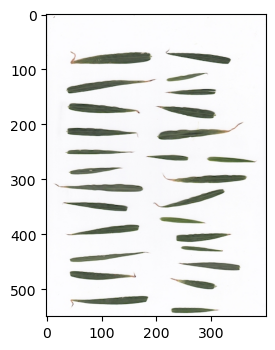

In [6]:
# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

## Section 2: Isolating plant, making binary mask, getting object(s)
* Requires successful import of image
* See Tools for Thresholding Plant Data for a full list of functions that can be used to create a binary mask

## Visualize colorspaces
The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

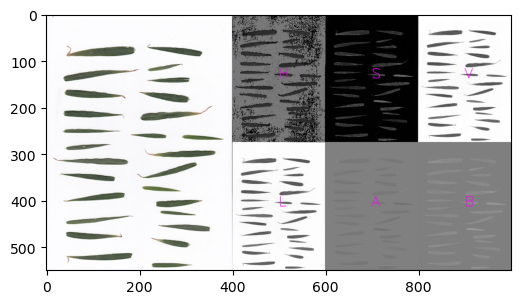

In [7]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

## Convert the color image to grayscale
Converts the input color image into the LAB colorspace and returns the L (lightness) channel as a grayscale image.

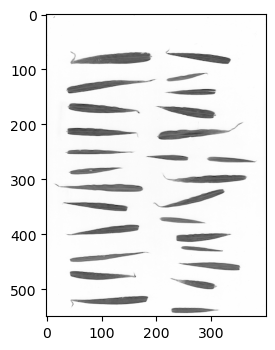

In [8]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
l = pcv.rgb2gray_lab(rgb_img = img, channel = 'l')

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak starting at 240 is from the lighter background pixels. The smaller peaks that represent leaves are between 80-110, and we can use the lower bound of the background peaks to estimate a good thresholding point, somewhere between 200-230/.

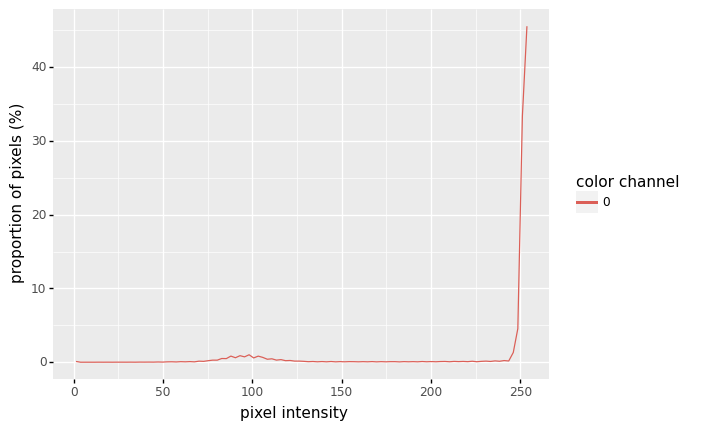

In [12]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=l)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 200-230 will segment the plant and background peaks. Because the leaves have darker pixels in this image, use object_type="dark" to do an inverse threshold.

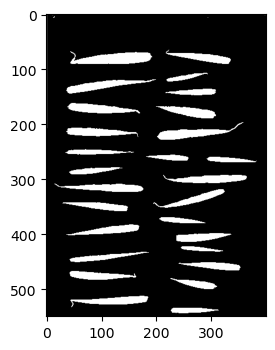

In [13]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
mask = pcv.threshold.binary(gray_img = l, threshold = 220, max_value = 255, object_type = 'dark')
#                                                      ^                                    ^
#                                                      |                                    |
#                                              change this value                    change this value


## Fill in background noise

Fill in grainy background noise in order to isolate leaves from non-plant pixels that are captured by the mask.

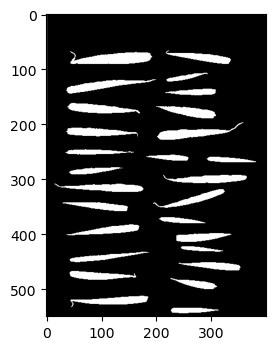

In [11]:
# Inputs:
#   bin_img = binary mask
#   size    = minimum object area size in pixels (integer), smaller objects will be filled 
mask_fill = pcv.fill(bin_img = mask, size = 40)

## Analyze and label leaf sizes

Use the visualize sizes function to calculate the size of each leaf and label each accordingly.

NOTE: The visualize functions is not in the current

In [14]:
# Inputs:
#   img = RGB image
#   mask = binary mask
#   num_objects = number of objects (leaves) within the image
# leaf_sizes = pcv.visualize.sizes(img = img, mask = mask_fill, num_objects = 27)

AttributeError: module 'plantcv.plantcv.visualize' has no attribute 'sizes'

## Identify seed objects for shape and color analysis
For shape and color analysis, we need to use find_objects from PlantCV to get the objects and object hierarchy that we need as inputs in the following analyses.

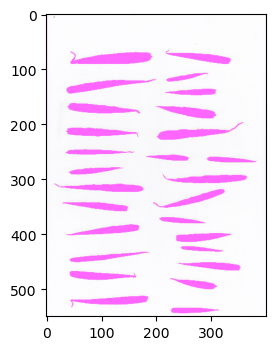

In [15]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
objects2, obj_hierarchy = pcv.find_objects(img=img, mask=mask_fill)

## Measure each leaf
To measure each leaf, iterate over the objects (which occur when obj_hierarchy[0][i][3] == -1). For each object, the following steps are done:

1. Contours are consolidated, so that all contours that correspond to one leaf are compiled into a single object and mask.
2. Analyze leaf shape
3. Analyze leaf color

In [19]:
# Create a copy of the RGB image for shape analysis annotations
# Inputs:
#   img = image
shape_img = np.copy(img)

# Turn off plot debugging
pcv.params.debug = None

# Interate through all objects and do a shape and color analysis
# for i in range(0, 27): 
# The loop above takes up too much memory for binder, but ideally you'd loop over every seed 

# For demonstration purposes, we can loop through the first 15 objects
for i in range(0, 15):
    # Check to see if the object has an offshoot in the hierarchy
    if obj_hierarchy[0][i][3] == -1:
        # Create an object and a mask for one object
        #
        # Inputs:
        #   img - rgb image
        #   contours - list entry i in objects2
        #   hierarchy - np.array of obj_hierarchy[0][1]
        seed, seed_mask = pcv.object_composition(img=img, contours=[objects2[i]], hierarchy=np.array([[obj_hierarchy[0][i]]]))
        
        # Analyze shape of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   mask - mask created of single seed
        #   label - label for each seed in image
        shape_img = pcv.analyze_object(img=shape_img, obj=seed, mask=seed_mask, label=f"seed{i}")
        
        # Analyze color of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   hist_plot_type - 'all', or None for no histogram plot
        #   label - 'default'      
        color_img = pcv.analyze_color(rgb_img=img, mask=mask_fill, hist_plot_type=None, label="default")

## Visualize shape and color analysis of leaves
Since debugging was turned off during the for loop, as plotting all analysis results significantly slows down the analysis, we can plot the final shape and color analyses to ensure that the results look correct.

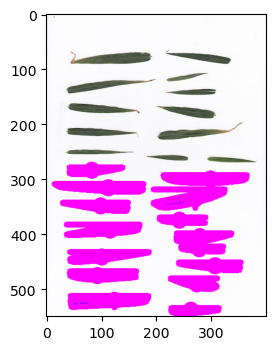

In [27]:
# Inputs:
#   img = image for shape analysis
pcv.plot_image(img=shape_img)

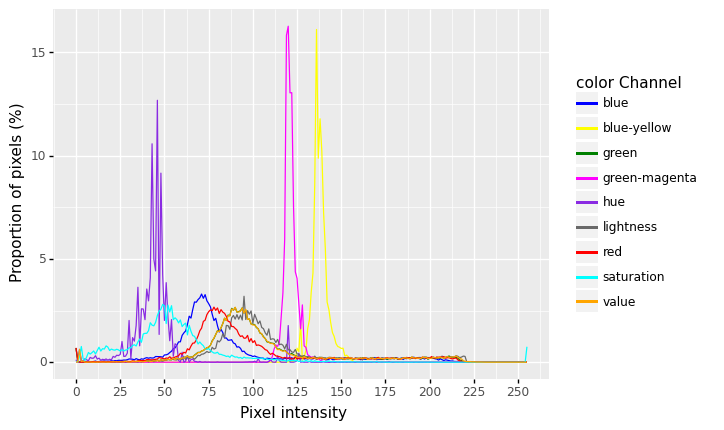

In [28]:
# Inputs:
#   img = image for color analysis
pcv.plot_image(img=color_img)

## Save results
During analysis, measurements are stored in the background in the outputs recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object, and 'blue_frequencies', 'green_frequencies', 'red_frequencies', 'lightness_frequencies', 'green-magenta_frequencies', 'blue-yellow_frequencies', 'hue_frequencies', 'saturation_frequencies', 'value_frequencies', 'hue_circular_mean', 'hue_circular_std', 'hue_median' using analyze_color.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [29]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result, outformat="csv")